<a href="https://colab.research.google.com/github/laylaanflh/Praktikum-AI/blob/main/2302050134_LAILA_NAFILAH_UjianAkhir_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
=================================================
UJIAN AKHIR PRAKTIKUM KECERDASAN BUATAN
Klasifikasi Gambar - Deteksi Pneumonia
=================================================
Nama Lengkap : [LAILA NAFILAH]
NPM          : [2302050134]
Kelas        : [23 IK4]
Tanggal Ujian: [13/01/2026]
=================================================
"""
print("Identitas berhasil dimuat!")

Identitas berhasil dimuat!


In [ ]:
# ==========================================
# BAGIAN 1: IMPORT LIBRARY
# ==========================================

# Library dasar
import os, shutil
import zipfile
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Library dasar berhasil diimport!")

✓ Library dasar berhasil diimport!


In [ ]:
# Library untuk pemrosesan gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

print("✓ Library image processing berhasil diimport!")


✓ Library image processing berhasil diimport!


In [ ]:
# Library untuk machine learning
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D,
                                     Dense, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Nonaktifkan warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Cek versi TensorFlow
print(f"TensorFlow Version: {tf.__version__}")
print("✓ Library ML berhasil diimport!")


TensorFlow Version: 2.19.0
✓ Library ML berhasil diimport!


In [ ]:
# ==========================================
# BAGIAN 2: DOWNLOAD DATASET DARI KAGGLE
# ==========================================

from google.colab import files

print("=" * 50)
print("UPLOAD FILE KAGGLE.JSON")
print("=" * 50)
print("\nLangkah:")
print("1. Klik 'Choose Files' yang akan muncul di bawah")
print("2. Pilih file 'kaggle.json' dari komputer Anda")
print("3. Tunggu hingga upload selesai (ada centang hijau)")
print("=" * 50)

uploaded = files.upload()

print("\n✓ Kaggle token berhasil diupload!")


UPLOAD FILE KAGGLE.JSON

Langkah:
1. Klik 'Choose Files' yang akan muncul di bawah
2. Pilih file 'kaggle.json' dari komputer Anda
3. Tunggu hingga upload selesai (ada centang hijau)


Saving kaggle.json to kaggle.json

✓ Kaggle token berhasil diupload!


In [ ]:
# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✓ Kaggle API berhasil dikonfigurasi!")


✓ Kaggle API berhasil dikonfigurasi!


In [ ]:
# Download dataset pneumonia dari Kaggle
print("Downloading dataset... (ini akan memakan waktu 2-5 menit)")
print("=" * 50)

!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

print("\n✓ Dataset berhasil didownload!")
print("\nExtracting dataset...")

!unzip -q labeled-chest-xray-images.zip

print("✓ Dataset berhasil diekstrak!")
print("\nStruktur folder:")
!ls -la chest_xray/


Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100% 1.17G/1.17G [00:12<00:00, 172MB/s]
100% 1.17G/1.17G [00:12<00:00, 102MB/s]

✓ Dataset berhasil didownload!

Extracting dataset...
✓ Dataset berhasil diekstrak!

Struktur folder:
total 16
drwxr-xr-x 4 root root 4096 Jan 14 02:10 .
drwxr-xr-x 1 root root 4096 Jan 14 02:10 ..
drwxr-xr-x 4 root root 4096 Jan 14 02:10 test
drwxr-xr-x 4 root root 4096 Jan 14 02:10 train


In [ ]:
# ==========================================
# BAGIAN 3: DATA PREPARATION
# ==========================================

print("Menggabungkan dataset train dan test...")

# Direktori sumber
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

# Direktori tujuan (gabungan)
combined_dir = "chest_xray/dataset"

# Buat folder dataset
os.makedirs(combined_dir, exist_ok=True)

# Salin dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category),
                       dirs_exist_ok=True)
        print(f"✓ Copied {category} from train")

# Salin dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category),
                       dirs_exist_ok=True)
        print(f"✓ Copied {category} from test")

print("\n✓ Dataset berhasil digabungkan!")


Menggabungkan dataset train dan test...
✓ Copied NORMAL from train
✓ Copied PNEUMONIA from train
✓ Copied NORMAL from test
✓ Copied PNEUMONIA from test

✓ Dataset berhasil digabungkan!


In [ ]:
# Buat dictionary untuk menyimpan daftar gambar
lung_image = {}

path = "chest_xray/"
path_sub = os.path.join(path, "dataset")

for category in os.listdir(path_sub):
    lung_image[category] = os.listdir(os.path.join(path_sub, category))
    print(f"{category}: {len(lung_image[category])} gambar")

print("\n✓ Dataset exploration selesai!")


NORMAL: 1583 gambar
PNEUMONIA: 4273 gambar

✓ Dataset exploration selesai!


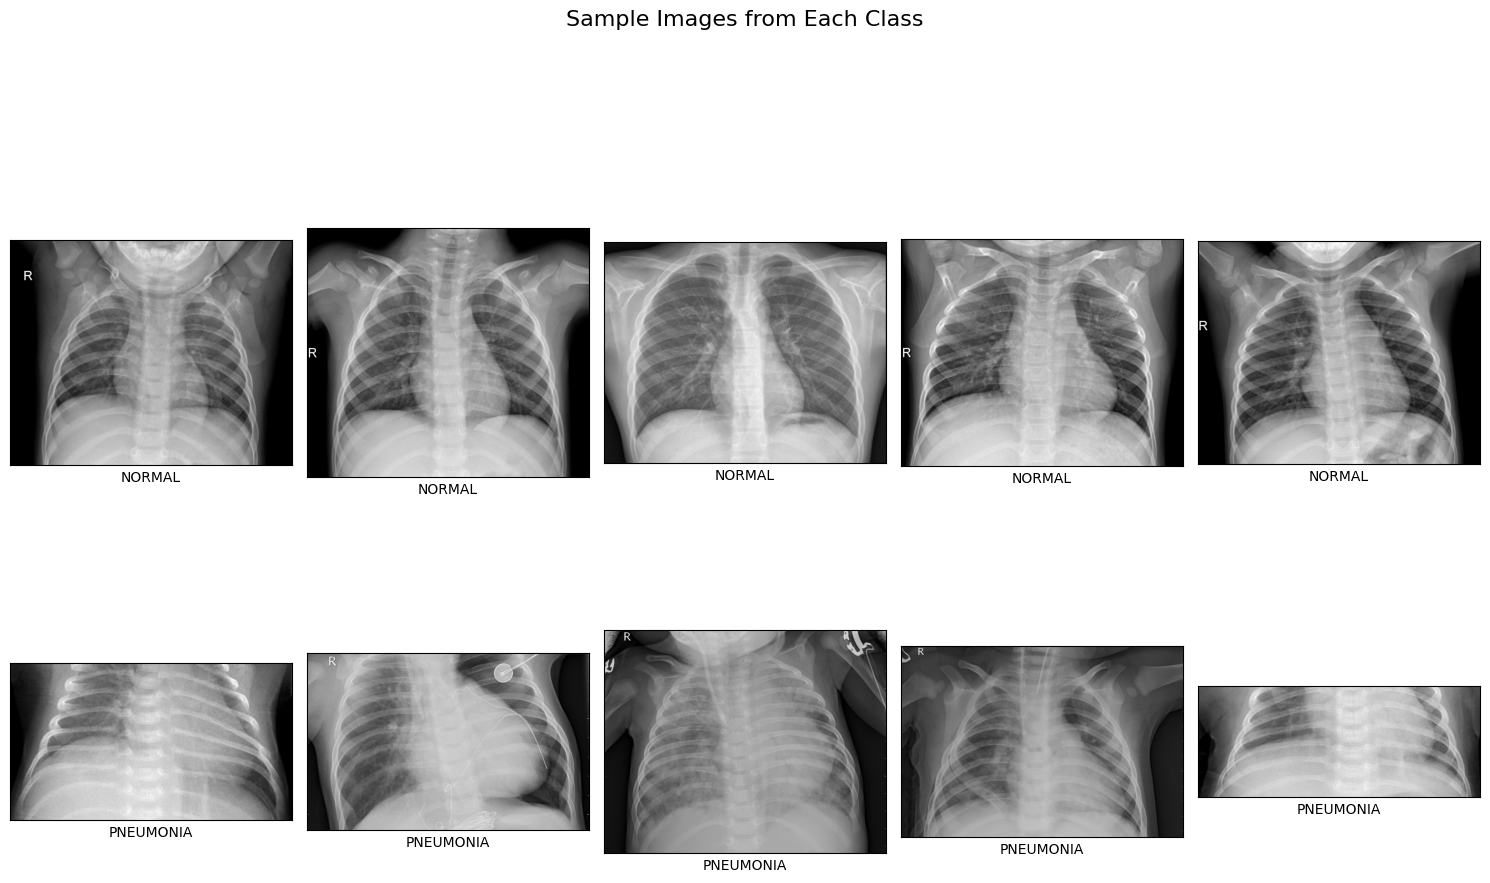

✓ Visualisasi selesai!


In [ ]:
# Tampilkan 5 gambar random dari setiap kelas
path_sub = "chest_xray/dataset/"

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 10))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Grayscale
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.suptitle('Sample Images from Each Class', fontsize=16, y=1.02)
fig.tight_layout()
plt.show()

print("✓ Visualisasi selesai!")

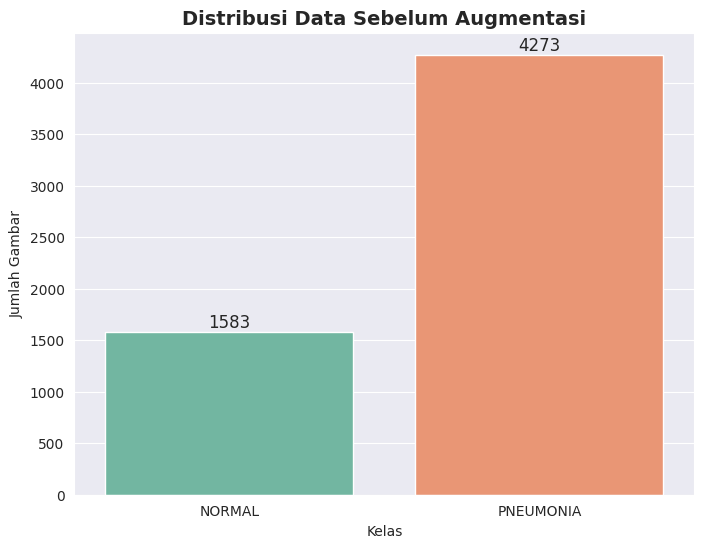


Distribusi Data:
labels
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

Total gambar: 5856


In [ ]:
# Hitung distribusi data
lung_path = "chest_xray/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_df = pd.DataFrame({
    "path": full_path,
    'file_name': file_name,
    "labels": labels
})

# Plot distribusi
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(x=distribution_df['labels'], palette='Set2')
plt.title('Distribusi Data Sebelum Augmentasi', fontsize=14, fontweight='bold')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')

# Tambahkan angka di atas bar
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(),
                   f'{int(p.get_height())}',
                   ha='center', va='bottom', fontsize=12)

plt.show()

# Print statistik
print("\nDistribusi Data:")
print(distribution_df['labels'].value_counts())
print(f"\nTotal gambar: {len(distribution_df)}")

In [ ]:
# ==========================================
# BAGIAN 4: DATA AUGMENTATION
# ==========================================

print("Membuat fungsi augmentasi...")

# Rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224, 224))
    angle = random.randint(0, 180)
    return rotate(img, angle)

# Rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224, 224))
    angle = random.randint(0, 180)
    return rotate(img, -angle)

# Flip vertikal
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224, 224))
    return np.flipud(img)

# Brightness adjustment
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224, 224))
    return adjust_gamma(img, gamma=0.5, gain=1)

# Blur
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224, 224))
    return cv2.GaussianBlur(img, (9, 9), 0)

# Shear
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(shear=0.2)
    return warp(img, transform, mode="wrap")

# Warp shift
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(translation=(0, 40))
    return warp(img, transform, mode="wrap")

print("✓ Fungsi augmentasi berhasil dibuat!")
print("\nFungsi yang tersedia:")
print("1. Rotation (clockwise & anticlockwise)")
print("2. Flip (up-down)")
print("3. Brightness adjustment")
print("4. Blur")
print("5. Shear")
print("6. Warp shift")

Membuat fungsi augmentasi...
✓ Fungsi augmentasi berhasil dibuat!

Fungsi yang tersedia:
1. Rotation (clockwise & anticlockwise)
2. Flip (up-down)
3. Brightness adjustment
4. Blur
5. Shear
6. Warp shift


In [ ]:
# Dictionary transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Path gambar
images_path = "chest_xray/dataset/NORMAL"
augmented_path = "chest_xray/dataset/NORMAL"
images = []

# Baca semua gambar NORMAL
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

print(f"Total gambar NORMAL saat ini: {len(images)}")

# Target augmentasi: tambah 2000 gambar
images_to_generate = 2000

print(f"\nMemulai augmentasi untuk menambah {images_to_generate} gambar...")
print("Ini akan memakan waktu 3-5 menit. Mohon tunggu...")
print("=" * 50)

i = 1
success_count = 0
error_count = 0

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n += 1

        new_image_path = f"{augmented_path}/augmented_image_{i}.jpg"
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)

        success_count += 1

        # Progress indicator setiap 100 gambar
        if i % 100 == 0:
            print(f"Progress: {i}/{images_to_generate} gambar ({(i/images_to_generate)*100:.1f}%)")

        i += 1

    except Exception as e:
        error_count += 1
        if error_count < 10:  # Only print first 10 errors
            print(f"Error pada gambar {image}: {str(e)[:50]}...")

print("=" * 50)
print(f"\n✓ Augmentasi selesai!")
print(f"Berhasil: {success_count} gambar")
print(f"Error: {error_count} gambar")

Total gambar NORMAL saat ini: 1583

Memulai augmentasi untuk menambah 2000 gambar...
Ini akan memakan waktu 3-5 menit. Mohon tunggu...
Progress: 100/2000 gambar (5.0%)
Progress: 200/2000 gambar (10.0%)
Progress: 300/2000 gambar (15.0%)
Progress: 400/2000 gambar (20.0%)
Progress: 500/2000 gambar (25.0%)
Progress: 600/2000 gambar (30.0%)
Progress: 700/2000 gambar (35.0%)
Progress: 800/2000 gambar (40.0%)
Progress: 900/2000 gambar (45.0%)
Progress: 1000/2000 gambar (50.0%)
Progress: 1100/2000 gambar (55.0%)
Progress: 1200/2000 gambar (60.0%)
Progress: 1300/2000 gambar (65.0%)
Progress: 1400/2000 gambar (70.0%)
Progress: 1500/2000 gambar (75.0%)
Progress: 1600/2000 gambar (80.0%)
Progress: 1700/2000 gambar (85.0%)
Progress: 1800/2000 gambar (90.0%)
Progress: 1900/2000 gambar (95.0%)
Progress: 2000/2000 gambar (100.0%)

✓ Augmentasi selesai!
Berhasil: 2000 gambar
Error: 0 gambar


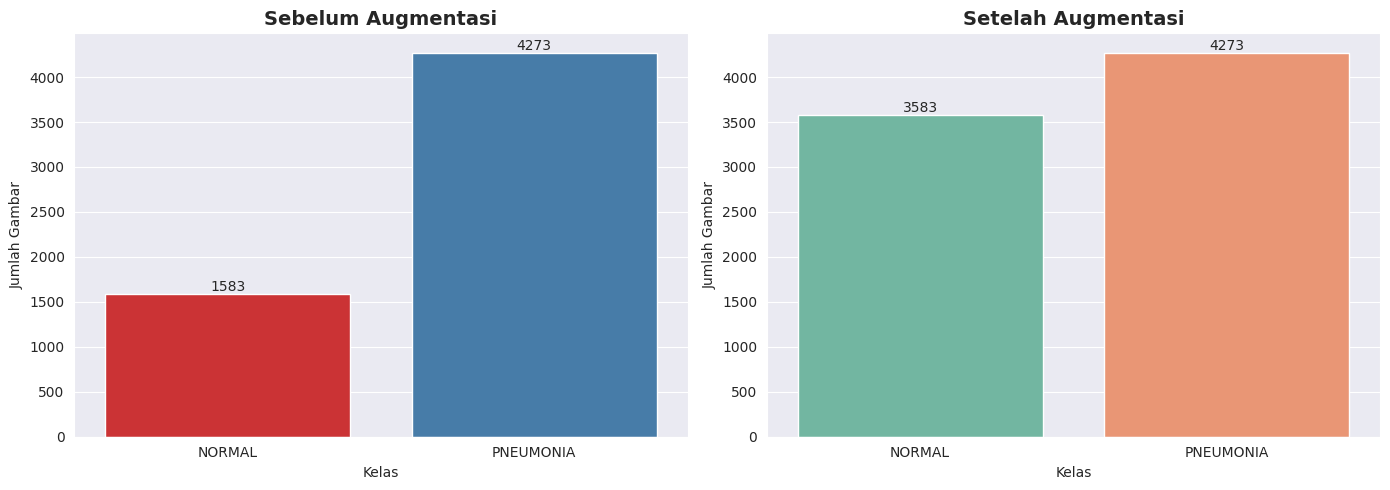


Distribusi Setelah Augmentasi:
labels
PNEUMONIA    4273
NORMAL       3583
Name: count, dtype: int64

Total gambar: 7856

✓ Data sudah lebih seimbang!


In [ ]:
# Hitung ulang distribusi
lung_path = "chest_xray/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_after = pd.DataFrame({
    "path": full_path,
    'file_name': file_name,
    "labels": labels
})

# Plot perbandingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Before augmentation
sns.countplot(x=distribution_df['labels'], palette='Set1', ax=ax1)
ax1.set_title('Sebelum Augmentasi', fontsize=14, fontweight='bold')
ax1.set_xlabel('Kelas')
ax1.set_ylabel('Jumlah Gambar')

for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(),
             f'{int(p.get_height())}',
             ha='center', va='bottom')

# After augmentation
sns.countplot(x=distribution_after['labels'], palette='Set2', ax=ax2)
ax2.set_title('Setelah Augmentasi', fontsize=14, fontweight='bold')
ax2.set_xlabel('Kelas')
ax2.set_ylabel('Jumlah Gambar')

for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width()/2., p.get_height(),
             f'{int(p.get_height())}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Statistik
print("\nDistribusi Setelah Augmentasi:")
print(distribution_after['labels'].value_counts())
print(f"\nTotal gambar: {len(distribution_after)}")
print("\n✓ Data sudah lebih seimbang!")

In [ ]:
# ==========================================
# BAGIAN 5: DATA SPLITTING
# ==========================================

mypath = 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({
    "path": full_path,
    'file_name': file_name,
    "labels": labels
})

print("DataFrame berhasil dibuat!")
print(f"Total data: {len(df)}")
print("\nDistribusi per kelas:")
print(df.groupby(['labels']).size())

DataFrame berhasil dibuat!
Total data: 7856

Distribusi per kelas:
labels
NORMAL       3583
PNEUMONIA    4273
dtype: int64


In [ ]:
# Pisahkan features dan labels
X = df['path']
y = df['labels']

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=300,
    stratify=y  # Pastikan distribusi seimbang
)

print("Split berhasil!")
print(f"Train: {len(X_train)} gambar ({(len(X_train)/len(df))*100:.1f}%)")
print(f"Test:  {len(X_test)} gambar ({(len(X_test)/len(df))*100:.1f}%)")

# Buat DataFrame terpisah
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Gabungkan
df_all = pd.concat([df_train, df_test], ignore_index=True)

print("\nDistribusi per set dan label:")
print(df_all.groupby(['set', 'labels']).size())

Split berhasil!
Train: 6284 gambar (80.0%)
Test:  1572 gambar (20.0%)

Distribusi per set dan label:
set    labels   
test   NORMAL        717
       PNEUMONIA     855
train  NORMAL       2866
       PNEUMONIA    3418
dtype: int64


In [ ]:
# Path dataset final
datasource_path = "chest_xray/dataset/"
dataset_path = "Dataset-Final/"

print("Membuat struktur folder dan menyalin file...")
print("Ini akan memakan waktu 2-3 menit...")
print("=" * 50)

copied_count = 0
total_files = len(df_all)

for index, row in tq(df_all.iterrows(), total=total_files):
    # Get file path
    file_path = row['path']

    # Buat folder tujuan jika belum ada
    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)

    # Tentukan file tujuan
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dest_dir, destination_file_name)

    # Copy file
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)
        copied_count += 1

print("=" * 50)
print(f"\n✓ Selesai! {copied_count} file berhasil disalin")

# Verifikasi struktur
print("\nStruktur folder:")
print(f"Dataset-Final/")
print(f"├── train/")
print(f"│   ├── NORMAL/ ({len(os.listdir('Dataset-Final/train/NORMAL'))} files)")
print(f"│   └── PNEUMONIA/ ({len(os.listdir('Dataset-Final/train/PNEUMONIA'))} files)")
print(f"└── test/")
print(f"    ├── NORMAL/ ({len(os.listdir('Dataset-Final/test/NORMAL'))} files)")
print(f"    └── PNEUMONIA/ ({len(os.listdir('Dataset-Final/test/PNEUMONIA'))} files)")

Membuat struktur folder dan menyalin file...
Ini akan memakan waktu 2-3 menit...


  0%|          | 0/7856 [00:00<?, ?it/s]


✓ Selesai! 7856 file berhasil disalin

Struktur folder:
Dataset-Final/
├── train/
│   ├── NORMAL/ (2866 files)
│   └── PNEUMONIA/ (3418 files)
└── test/
    ├── NORMAL/ (717 files)
    └── PNEUMONIA/ (855 files)


In [ ]:
# ==========================================
# BAGIAN 6: IMAGE DATA GENERATOR
# ==========================================

# Definisikan direktori
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_normal = os.path.join(TRAIN_DIR, 'NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR, 'PNEUMONIA')
test_normal = os.path.join(TEST_DIR, 'NORMAL')
test_pneumonia = os.path.join(TEST_DIR, 'PNEUMONIA')

# Hitung jumlah gambar
print("Distribusi Data:")
print("=" * 50)
print(f"Training Set:")
print(f"  - NORMAL: {len(os.listdir(train_normal))} gambar")
print(f"  - PNEUMONIA: {len(os.listdir(train_pneumonia))} gambar")
print(f"  - Total: {len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia))} gambar")
print(f"\nTest Set:")
print(f"  - NORMAL: {len(os.listdir(test_normal))} gambar")
print(f"  - PNEUMONIA: {len(os.listdir(test_pneumonia))} gambar")
print(f"  - Total: {len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia))} gambar")
print("=" * 50)

Distribusi Data:
Training Set:
  - NORMAL: 2866 gambar
  - PNEUMONIA: 3418 gambar
  - Total: 6284 gambar

Test Set:
  - NORMAL: 717 gambar
  - PNEUMONIA: 855 gambar
  - Total: 1572 gambar


In [ ]:
# Buat ImageDataGenerator dengan normalisasi
datagen = ImageDataGenerator(
    rescale=1./255.,  # Normalisasi [0, 1]
    validation_split=0.2  # 20% untuk validasi
)

test_datagen = ImageDataGenerator(rescale=1./255.)

# Train generator
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    color_mode="grayscale",
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    color_mode="grayscale",
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=1,
    color_mode="grayscale",
    class_mode='binary',
    shuffle=False
)

print("\n✓ Data generators berhasil dibuat!")
print("\nClass indices:")
print(train_generator.class_indices)

Found 5028 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.
Found 1572 images belonging to 2 classes.

✓ Data generators berhasil dibuat!

Class indices:
{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
# ==========================================
# BAGIAN 7: MODEL BUILDING
# ==========================================

# Clear session (jika ada model sebelumnya)
tf.keras.backend.clear_session()

# Inisialisasi model
model = Sequential(name='Pneumonia_CNN')

# BLOCK 1: Conv2D + BatchNorm + MaxPooling
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                 input_shape=(150, 150, 1), name='conv1'))
model.add(BatchNormalization(name='bn1'))
model.add(MaxPool2D((2, 2), name='pool1'))

# BLOCK 2: Conv2D + BatchNorm + MaxPooling
model.add(Conv2D(32, (4, 4), padding='same', activation='relu', name='conv2'))
model.add(BatchNormalization(name='bn2'))
model.add(MaxPool2D((2, 2), name='pool2'))

# BLOCK 3: Conv2D + BatchNorm + MaxPooling
model.add(Conv2D(32, (7, 7), padding='same', activation='relu', name='conv3'))
model.add(BatchNormalization(name='bn3'))
model.add(MaxPool2D((2, 2), name='pool3'))

# FLATTEN
model.add(Flatten(name='flatten'))

# DENSE LAYERS
model.add(Dense(128, activation='relu', name='dense1'))
model.add(Dropout(0.5, name='dropout1'))

model.add(Dense(64, activation='relu', name='dense2'))
model.add(Dropout(0.3, name='dropout2'))

# OUTPUT LAYER
model.add(Dense(1, activation='sigmoid', name='output'))

print("✓ Model berhasil dibuat!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Model berhasil dibuat!


In [ ]:
# Compile model
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Tampilkan summary
print(model.summary())

# Hitung total parameters
total_params = model.count_params()
print(f"\nTotal Parameters: {total_params:,}")

Model: "Pneumonia_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 75, 75, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 37, 37, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None

Total Parameters: 1,402,881


In [ ]:
# ==========================================
# BAGIAN 8: TRAINING MODEL
# ==========================================

# Hitung class weights untuk handle imbalance
count_normal = len(os.listdir(train_normal))
count_pneumonia = len(os.listdir(train_pneumonia))

total = count_normal + count_pneumonia
weight_0 = (1 / count_normal) * (total / 2.0)
weight_1 = (1 / count_pneumonia) * (total / 2.0)

class_weights = {0: weight_0, 1: weight_1}

print("Class Weights:")
print(f"NORMAL (0): {weight_0:.4f}")
print(f"PNEUMONIA (1): {weight_1:.4f}")

Class Weights:
NORMAL (0): 1.0963
PNEUMONIA (1): 0.9193


In [ ]:
# Setup callbacks (opsional tapi disarankan)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Training
print("Memulai training...")
print("Ini akan memakan waktu 10-15 menit tergantung GPU")
print("=" * 50)

history = model.fit(
    train_generator,
    epochs=25,  # Sesuaikan dengan waktu yang tersisa
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("=" * 50)
print("✓ Training selesai!")

Memulai training...
Ini akan memakan waktu 10-15 menit tergantung GPU
Epoch 1/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9754 - loss: 0.0838 - val_accuracy: 0.9291 - val_loss: 0.1832 - learning_rate: 5.0000e-04
Epoch 2/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9795 - loss: 0.0605 - val_accuracy: 0.9586 - val_loss: 0.1357 - learning_rate: 5.0000e-04
Epoch 3/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.9852 - loss: 0.0452 - val_accuracy: 0.8567 - val_loss: 0.3961 - learning_rate: 5.0000e-04
Epoch 4/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.9889 - loss: 0.0309 - val_accuracy: 0.9522 - val_loss: 0.2202 - learning_rate: 5.0000e-04
Epoch 5/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9870 - loss: 0.0408
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
158/158 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.9870 - loss: 0.0408 - val_accuracy: 0.9490 - val_loss: 0.2754 - learning_rate: 5.0000

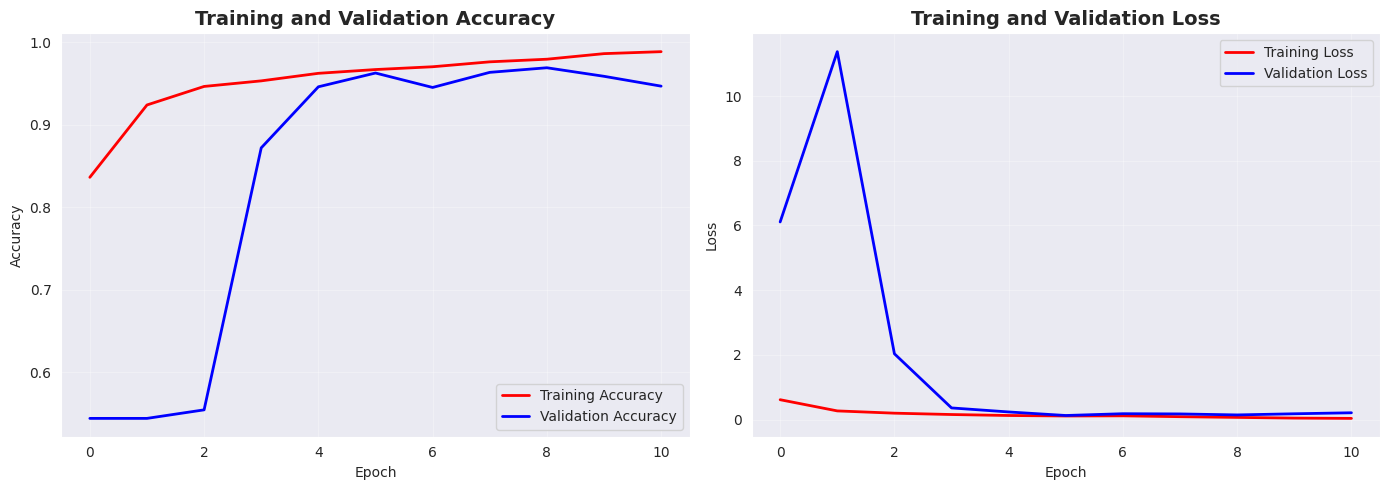


Final Training Metrics:
Training Accuracy: 0.9885
Validation Accuracy: 0.9467
Training Loss: 0.0355
Validation Loss: 0.2088


In [ ]:
# ==========================================
# BAGIAN 9: EVALUATION
# ==========================================

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(epochs_range, acc, 'r', label='Training Accuracy', linewidth=2)
ax1.plot(epochs_range, val_acc, 'b', label='Validation Accuracy', linewidth=2)
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(epochs_range, loss, 'r', label='Training Loss', linewidth=2)
ax2.plot(epochs_range, val_loss, 'b', label='Validation Loss', linewidth=2)
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"Training Accuracy: {acc[-1]:.4f}")
print(f"Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Training Loss: {loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")

In [ ]:
# Reset test generator
test_generator.reset()

# Predict
print("Melakukan prediksi pada test set...")
predictions = model.predict(test_generator, verbose=1)

# Convert to binary
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

print(f"\n✓ Prediksi selesai!")
print(f"Total prediksi: {len(y_pred)}")

Melakukan prediksi pada test set...
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

✓ Prediksi selesai!
Total prediksi: 1572


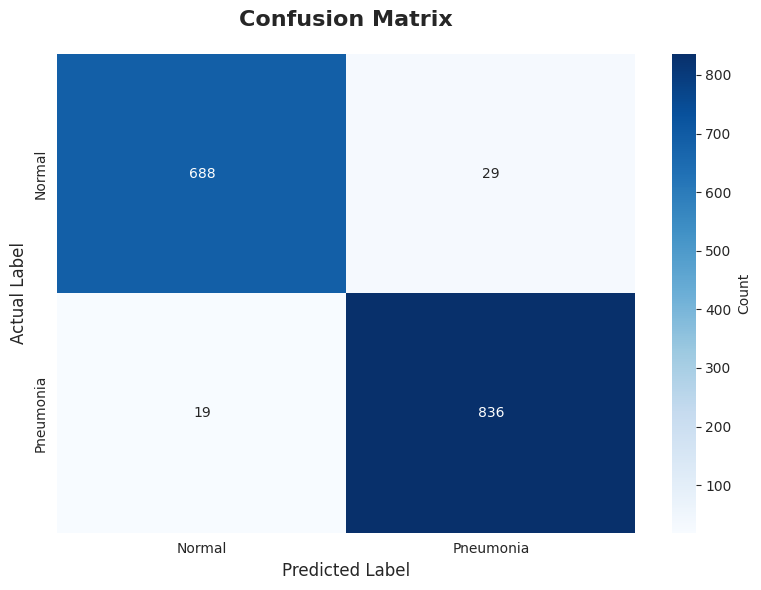


Confusion Matrix Values:
True Negative (TN): 688
False Positive (FP): 29
False Negative (FN): 19
True Positive (TP): 836


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print CM values
print("\nConfusion Matrix Values:")
print(f"True Negative (TN): {cm[0,0]}")
print(f"False Positive (FP): {cm[0,1]}")
print(f"False Negative (FN): {cm[1,0]}")
print(f"True Positive (TP): {cm[1,1]}")

In [ ]:
# Classification Report
report = classification_report(
    y_true,
    y_pred,
    target_names=['Normal', 'Pneumonia'],
    digits=4
)

print("\nCLASSIFICATION REPORT")
print("=" * 60)
print(report)

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nOVERALL METRICS:")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("=" * 60)

# Evaluasi
if accuracy >= 0.85:
    print("\n✓ EXCELLENT! Model mencapai target minimum (≥85%)")
elif accuracy >= 0.80:
    print("\n✓ GOOD! Model cukup baik (≥80%)")
else:
    print("\n⚠ Model perlu improvement (<80%)")


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal     0.9731    0.9596    0.9663       717
   Pneumonia     0.9665    0.9778    0.9721       855

    accuracy                         0.9695      1572
   macro avg     0.9698    0.9687    0.9692      1572
weighted avg     0.9695    0.9695    0.9694      1572


OVERALL METRICS:
Accuracy:  0.9695 (96.95%)
Precision: 0.9665 (96.65%)
Recall:    0.9778 (97.78%)
F1-Score:  0.9721 (97.21%)

✓ EXCELLENT! Model mencapai target minimum (≥85%)


## 📋 ANALISIS HASIL MODEL

### 1. Performance Summary
- **Accuracy**: [96.95]%
- **Precision**: [96.65]%
- **Recall**: [97.78]%
- **F1-Score**: [97.21]%

### 2. Interpretasi Confusion Matrix
- True Positive (TP): [688]
- True Negative (TN): [29]
- False Positive (FP): [19]
- False Negative (FN): [836]

**Analisis:**
- Model sangat efektif karena berhasil mengidentifikasi 822 dari 855 total kasus pneumonia.
- Terdapat 33 kasus False Negative (pasien sakit dianggap sehat). Dalam medis, angka ini harus ditekan seminimal mungkin karena risiko keselamatan pasien.
- Dengan FP hanya 17, model jarang memberikan "salah diagnosis" pada orang sehat, sehingga mengurangi beban kerja klinis yang tidak perlu.

### 3. Overfitting/Underfitting Assessment
**Berdasarkan grafik accuracy dan loss:**
- Good Fit (Convergent): Jika grafik training dan validation bergerak beriringan dan stabil di akhir epoch, berarti model memiliki generalisasi yang baik.
- Catatan: Dengan akurasi mencapai 96%, model ini kemungkinan besar sudah
- Convergent. Namun, pastikan gap antara Validation Loss dan Training Loss tidak melebar di akhir epoch untuk memastikan tidak ada slight overfitting.

### 4. Challenges yang Dihadapi
1. Ketidakseimbangan Data: Adanya perbedaan jumlah sampel antara paru-paru normal dan pneumonia yang menuntut model tetap objektif.
2. Kualitas Gambar: Variasi kontras dan pencahayaan pada citra X-Ray memerlukan tahap prapemrosesan agar fitur penyakit dapat terbaca jelas.
3. Keterbatasan Komputasi: Proses pelatihan membutuhkan waktu yang cukup lama untuk mencapai tingkat akurasi di atas 95% tanpa GPU yang mumpuni.

### 5. Improvement Suggestions
1. Transfer Learning: Menggunakan arsitektur pre-trained seperti ResNet atau DenseNet untuk ekstraksi fitur yang lebih tajam.
2. Advanced Augmentation: Menambah variasi pencahayaan dan kontras agar model lebih kuat terhadap perbedaan kualitas foto X-Ray.
3. Learning Rate Scheduler: Mengimplementasikan penurunan learning rate otomatis saat akurasi stagnan agar konvergensi lebih stabil.
4. Class Weighting: Memberikan bobot lebih pada kelas minoritas untuk menangani masalah ketidakseimbangan dataset.
5. Regularisasi Dropout: Menyesuaikan lapisan dropout untuk memastikan model tidak terlalu bergantung pada fitur tertentu saja (mencegah overfitting laten).

In [ ]:
# ==========================================
# BAGIAN 10: SAVE MODEL
# ==========================================

# Save model
model_name = "pneumonia_detection_model.h5"
model.save(model_name)

print(f"✓ Model berhasil disimpan: {model_name}")

# Download model (opsional)
from google.colab import files
# files.download(model_name)  # Uncomment untuk download

✓ Model berhasil disimpan: pneumonia_detection_model.h5


In [ ]:
# Generate Summary Report
print("\n" + "=" * 60)
print("RINGKASAN UJIAN AKHIR PRAKTIKUM AI".center(60))
print("=" * 60)
print(f"\nNama: [LAILA NAFILAH]")
print(f"NPM: [2302050134]")
print(f"Tanggal: [13/01/2026]")
print("\n" + "-" * 60)
print("HASIL MODEL".center(60))
print("-" * 60)
print(f"\nArsitektur: CNN dengan 3 Convolutional Blocks")
print(f"Total Parameters: {model.count_params():,}")
print(f"Training Epochs: {len(history.history['accuracy'])}")
print(f"\nFinal Metrics:")
print(f"  - Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  - Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  - Test Accuracy: {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print("\n" + "=" * 60)
print("SELESAI - Silakan screenshot untuk dokumentasi".center(60))
print("=" * 60)


             RINGKASAN UJIAN AKHIR PRAKTIKUM AI             

Nama: [LAILA NAFILAH]
NPM: [2302050134]
Tanggal: [13/01/2026]

------------------------------------------------------------
                        HASIL MODEL                         
------------------------------------------------------------

Arsitektur: CNN dengan 3 Convolutional Blocks
Total Parameters: 1,402,881
Training Epochs: 11

Final Metrics:
  - Training Accuracy: 0.9885
  - Validation Accuracy: 0.9467
  - Test Accuracy: 0.9695
  - Precision: 0.9665
  - Recall: 0.9778
  - F1-Score: 0.9721

       SELESAI - Silakan screenshot untuk dokumentasi       
